In [1]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import RepeatVector
from keras.layers import Dropout
from numpy import hstack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [75]:
def form(yhat,y,mode,ix=3):
    tp=[]
    tn=[]
    fn=[]
    fp=[]
    yuzdelik=[[],[],[],[]]
    if mode==1:
        for index,i in enumerate(yhat):
            result=i[ix]-y[index-1,ix]
            if index==0:
                continue
            if y[index-1,ix]>y[index,ix]:#dusmus
                if result>0: 
                    fn.append(abs(i[ix]-y[index,ix]))#negatif
                    yuzdelik[2].append((y[index,ix]/y[index-1,ix]+0.001)-1)
                else:
                    tn.append(abs(i[ix]-y[index,ix]))
                    yuzdelik[3].append((y[index,ix]/y[index-1,ix]+0.001)-1)
            else:  #artmis
                if result>0: 
                    tp.append(abs(i[ix]-y[index,ix]))#negatif
                    yuzdelik[0].append((y[index,ix]/y[index-1,ix]+0.001)-1)
                else:
                    fp.append(abs(i[ix]-y[index,ix]))
                    yuzdelik[1].append((y[index,ix]/y[index-1,ix]+0.001)-1)
    elif mode==0:
        count_t=0
        count_g=0
        count_l=0
        count_w=[]
        count_ls=[]
        count_tr=[]
        price_pred=[]
        price_per=[]
        for index,i in enumerate(yhat):
            result=i-y[index-1]
            if index==0:
                continue
            if y[index-1]>y[index]:#dusmus
                if result>0: 
                    fn.append(abs(i-y[index]))#negatif
                    yuzdelik[2].append((y[index]/y[index-1]+0.001)-1)
                    price_per.append((y[index]/y[index-1]+0.001)-1)
                    count_ls.append(count_l)
                    count_tr.append(count_t)
                    price_pred.append(0)
                    count_l=0
                    count_t=0
                else:
                    tn.append(abs(i-y[index]))
                    yuzdelik[3].append((y[index]/y[index-1]+0.001)-1)
                    price_per.append((y[index]/y[index-1]+0.001)-1)
                    count_l+=1
                    count_t+=1
                    price_pred.append(1)
            else:  #artmis
                if result>0: 
                    tp.append(abs(i-y[index]))#pozitif
                    yuzdelik[0].append((y[index]/y[index-1]+0.001)-1)
                    price_per.append((y[index]/y[index-1]+0.001)-1)
                    count_g+=1
                    count_t+=1    
                    price_pred.append(1)

                else:
                    fp.append(abs(i-y[index]))
                    yuzdelik[1].append((y[index]/y[index-1]+0.001)-1)
                    price_per.append((y[index]/y[index-1]+0.001)-1)
                    count_w.append(count_g)
                    count_tr.append(count_t)
                    count_g=0
                    count_t=0
                    price_pred.append(0)
        
    print()
    print('Mean')
    print([np.mean(tp),"%{}".format(np.mean(yuzdelik[0])*100),"||||",np.mean(fp),"%{}".format(np.mean(yuzdelik[1])*100)])
    print([np.mean(fn),"-%{}".format(np.mean(np.abs(yuzdelik[2])*100)),"||||",np.mean(tn),"-%{}".format(np.mean(np.abs(yuzdelik[3]))*100)])
    print()
    print('Count')
    print([len(tp),len(fp)])
    print([len(fn),len(tn)])
    print("acc %{}".format((len(tp)+len(tn))/(len(tp)+len(fp)+len(fn)+len(tn))))
    print()
    print('Max')
    print([np.max(tp),"%{}".format(np.max(yuzdelik[0])*100),"||||",np.max(fp),"%{}".format(np.max(yuzdelik[1])*100)])
    print([np.max(fn),"-%{}".format(np.max(np.abs(yuzdelik[2])*100)),"||||",np.max(tn),"-%{}".format(np.max(np.abs(yuzdelik[3]))*100)])
    print()
    print('Min')
    print([np.min(tp),"%{}".format(np.min(np.abs(yuzdelik[0]))*100),"||||",np.min(fp),"%{}".format(np.min(np.abs(yuzdelik[1]))*100)])
    print([np.min(fn),"-%{}".format(np.min(np.abs(yuzdelik[2]))*100),"||||",np.min(tn),"-%{}".format(np.min(np.abs(yuzdelik[3]))*100)])
    print()
    print("Means")
    print(np.mean(count_w),np.mean(count_ls),np.mean(count_tr))
    print()
    print("Maxs")
    print(np.max(count_w),np.max(count_ls),np.max(count_tr))
    money=100
    
    for i in range(len(price_per)):
        print(i,end=" ")
        if price_pred[i]==1:
            print("+++money was",money," and rate is",price_per[i])
            money+=((money*0.8)*abs(price_per[i]))*0.996#Comisyon
            print("money become ",money)
        else:
            print("---money was",money," and rate is",price_per[i])
            money-=((money*0.8)*abs(price_per[i]))*0.996#Comisyon
            print("money become ",money)
    return money


In [4]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [78]:
dataset= pd.read_csv('augmento_btc.csv')

In [79]:
dataset.head()

,date,listing_close,twitter_hacks,twitter_pessimistic_doubtful,twitter_banks,twitter_selling,twitter_market_manipulation,twitter_de_centralisation,twitter_angry,twitter_etf,...,reddit_buying,reddit_warning,reddit_annoyed_frustrated,reddit_price,reddit_use_case_applications,reddit_rumor,reddit_scam_fraud,reddit_airdrop,reddit_optimistic,reddit_negative
0,2016-11-01 01:00:00,706.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0,1.0,12.0
1,2016-11-01 02:00:00,709.99,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,2.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,1.0,8.0
2,2016-11-01 03:00:00,708.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,7.0
3,2016-11-01 04:00:00,702.85,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,5.0
4,2016-11-01 05:00:00,708.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,5.0,3.0,0.0,0.0,0.0,1.0,7.0


In [80]:
col=dataset.columns

In [81]:
for i,c in enumerate(col):
    print(i,c)

0 date
1 listing_close
2 twitter_hacks
3 twitter_pessimistic_doubtful
4 twitter_banks
5 twitter_selling
6 twitter_market_manipulation
7 twitter_de_centralisation
8 twitter_angry
9 twitter_etf
10 twitter_leverage
11 twitter_bottom
12 twitter_institutional_money
13 twitter_fomo
14 twitter_prediction
15 twitter_adoption
16 twitter_fearful_concerned
17 twitter_portfolio
18 twitter_fud_theme
19 twitter_whitepaper
20 twitter_announcements
21 twitter_technical_analysis
22 twitter_flippening
23 twitter_community
24 twitter_investing_trading
25 twitter_euphoric_excited
26 twitter_hodling
27 twitter_ico
28 twitter_bearish
29 twitter_going_short
30 twitter_uncertain
31 twitter_volume
32 twitter_risk
33 twitter_governance
34 twitter_ban
35 twitter_cheap
36 twitter_short_term_trading
37 twitter_fork
38 twitter_progress
39 twitter_shilling
40 twitter_bullish
41 twitter_happy
42 twitter_bubble
43 twitter_bots
44 twitter_hopeful
45 twitter_bug
46 twitter_open_source
47 twitter_token_economics
48 twitt

In [82]:
imp_col_index_good=[40,41,93,25,75]
imp_col_index_bad=[28,16,3,55,16,8,75,56,87]


icolindex_good=[0]
icolindex_bad=[0]

icolindex_good.extend([i for i in imp_col_index_good])
icolindex_good.extend([i+93 for i in imp_col_index_good])#for cointalk
icolindex_good.extend([i+93*2 for i in imp_col_index_good]) #for reddit

icolindex_bad.extend([i for i in imp_col_index_bad])
icolindex_bad.extend([i+93 for i in imp_col_index_bad])
icolindex_bad.extend([i+93*2 for i in imp_col_index_bad])


dataset_good=dataset.loc[:,col[icolindex_good]]
dataset_bad=dataset.loc[:,col[icolindex_bad]]

In [83]:
dataset_good

,date,twitter_bullish,twitter_happy,twitter_optimistic,twitter_euphoric_excited,twitter_mistrustful,bitcointalk_bullish,bitcointalk_happy,bitcointalk_optimistic,bitcointalk_euphoric_excited,bitcointalk_mistrustful,reddit_bullish,reddit_happy,reddit_optimistic,reddit_euphoric_excited,reddit_mistrustful
0,2016-11-01 01:00:00,2.0,1.0,3.0,1.0,0.0,1.0,1.0,4.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0
1,2016-11-01 02:00:00,2.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2016-11-01 03:00:00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0
3,2016-11-01 04:00:00,3.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0
4,2016-11-01 05:00:00,0.0,0.0,0.0,0.0,0.0,2.0,1.0,9.0,2.0,1.0,1.0,1.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44886,2021-12-15 07:00:00,5.0,0.0,0.0,1.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44887,2021-12-15 08:00:00,3.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44888,2021-12-15 09:00:00,7.0,1.0,2.0,2.0,0.0,1.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
44889,2021-12-15 10:00:00,2.0,0.0,2.0,0.0,0.0,4.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
dataset_good['date']=pd.to_datetime(dataset_good['date']).dt.date
dataset_bad['date']=pd.to_datetime(dataset_bad['date']).dt.date

In [85]:
dataset_good['date']

0        2016-11-01
1        2016-11-01
2        2016-11-01
3        2016-11-01
4        2016-11-01
            ...    
44886    2021-12-15
44887    2021-12-15
44888    2021-12-15
44889    2021-12-15
44890    2021-12-15
Name: date, Length: 44891, dtype: object

In [86]:
dataset_good=dataset_good.groupby('date').sum().sum(axis=1)
dataset_bad=dataset_bad.groupby('date').sum().sum(axis=1)

In [87]:
dataset= pd.concat([dataset_good,dataset_bad],axis=1)
dataset=dataset.rename(columns={0:'pos',1:'neg'})

In [88]:
dataset['sentiment']=(dataset['pos']-dataset['neg'])/(dataset['pos']+dataset['neg'])

In [89]:
dataset.head

<bound method NDFrame.head of               pos    neg  sentiment
date                               
2016-11-01  495.0  256.0   0.318242
2016-11-02  487.0  262.0   0.300401
2016-11-03  491.0  272.0   0.287025
2016-11-04  340.0  258.0   0.137124
2016-11-05  329.0  195.0   0.255725
...           ...    ...        ...
2021-12-11  309.0  186.0   0.248485
2021-12-12  278.0  164.0   0.257919
2021-12-13  400.0  242.0   0.246106
2021-12-14  369.0  232.0   0.227953
2021-12-15  141.0   82.0   0.264574

[1871 rows x 3 columns]>

In [90]:
[len(dataset[dataset['sentiment']<0]),len(dataset[dataset['sentiment']>0])]

[10, 1861]

In [91]:
dataset[dataset['sentiment']<0]

,pos,neg,sentiment
date,,,
2019-03-06,1185.0,1804.0,-0.207093
2019-09-26,931.0,954.0,-0.012202
2019-12-02,707.0,741.0,-0.023481
2020-03-09,868.0,886.0,-0.010262
2020-09-04,669.0,953.0,-0.175092
2021-05-13,4415.0,4452.0,-0.004173
2021-05-19,4170.0,4534.0,-0.041820
2021-06-08,1496.0,1577.0,-0.026359
2021-06-21,1365.0,1522.0,-0.054382


In [92]:
dataset

,pos,neg,sentiment
date,,,
2016-11-01,495.0,256.0,0.318242
2016-11-02,487.0,262.0,0.300401
2016-11-03,491.0,272.0,0.287025
2016-11-04,340.0,258.0,0.137124
2016-11-05,329.0,195.0,0.255725
...,...,...,...
2021-12-11,309.0,186.0,0.248485
2021-12-12,278.0,164.0,0.257919
2021-12-13,400.0,242.0,0.246106


In [93]:
dataset_c= pd.read_csv('cyripto.csv')
dataset_c.dtypes

timestamp    float64
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object

In [94]:
dataset_c['timestamp']=pd.to_datetime(dataset_c['timestamp'],unit='ms').dt.date

In [95]:
dataset_c['timestamp']

0       2016-11-01
1       2016-11-01
2       2016-11-02
3       2016-11-04
4       2016-11-04
           ...    
1866    2021-12-10
1867    2021-12-12
1868    2021-12-12
1869    2021-12-14
1870    2021-12-15
Name: timestamp, Length: 1871, dtype: object

In [96]:
dataset_c['timestamp']=pd.date_range(start="2016-11-01",end="2021-12-15")

In [97]:
dataset_c['timestamp']

0      2016-11-01
1      2016-11-02
2      2016-11-03
3      2016-11-04
4      2016-11-05
          ...    
1866   2021-12-11
1867   2021-12-12
1868   2021-12-13
1869   2021-12-14
1870   2021-12-15
Name: timestamp, Length: 1871, dtype: datetime64[ns]

In [98]:
dataset_c.index=dataset_c['timestamp']

In [99]:
rsi=calc_rsi(dataset_c)
rsi.index=dataset_c['timestamp']

In [100]:
dataset_c["rsi"]=rsi

In [101]:
dataset_c["rsi"][dataset_c["rsi"].isnull()]=0

<ipython-input-101-ad58284ab049>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_c["rsi"][dataset_c["rsi"].isnull()]=0


In [103]:
dataset=dataset_c

In [104]:
dataset

,timestamp,open,high,low,close,volume,rsi
timestamp,,,,,,,
2016-11-01,2016-11-01,699.403581,741.316204,696.756957,735.200067,4.633700e+07,0.000000
2016-11-02,2016-11-02,732.067064,747.296042,721.265225,745.204785,2.730184e+07,0.000000
2016-11-03,2016-11-03,744.608565,750.695934,674.115570,689.669090,6.709774e+07,0.000000
2016-11-04,2016-11-04,689.509491,709.126580,683.607847,704.062564,3.371150e+07,0.000000
2016-11-05,2016-11-05,706.525747,711.970714,688.419083,705.317849,1.437292e+07,0.000000
...,...,...,...,...,...,...,...
2021-12-11,2021-12-11,47167.986090,49513.222020,46787.423660,49413.991700,4.380321e+09,37.497626
2021-12-12,2021-12-12,49361.294630,50810.775300,48669.019370,50095.841890,3.831002e+09,39.626198
2021-12-13,2021-12-13,50100.819680,50222.799450,45716.686040,46734.828020,7.417394e+09,33.559255


In [52]:
dataset= pd.concat([dataset,dataset_c],axis=1)

In [53]:
dataset=dataset.dropna()
dataset=dataset.reset_index(drop=True)

In [54]:
dataset

,pos,neg,sentiment,timestamp,open,high,low,close,volume,rsi
0,495.0,256.0,0.318242,2016-11-01,699.403581,741.316204,696.756957,735.200067,4.633700e+07,0.000000
1,487.0,262.0,0.300401,2016-11-02,732.067064,747.296042,721.265225,745.204785,2.730184e+07,0.000000
2,491.0,272.0,0.287025,2016-11-03,744.608565,750.695934,674.115570,689.669090,6.709774e+07,0.000000
3,340.0,258.0,0.137124,2016-11-04,689.509491,709.126580,683.607847,704.062564,3.371150e+07,0.000000
4,329.0,195.0,0.255725,2016-11-05,706.525747,711.970714,688.419083,705.317849,1.437292e+07,0.000000
...,...,...,...,...,...,...,...,...,...,...
1866,309.0,186.0,0.248485,2021-12-11,47167.986090,49513.222020,46787.423660,49413.991700,4.380321e+09,37.497626
1867,278.0,164.0,0.257919,2021-12-12,49361.294630,50810.775300,48669.019370,50095.841890,3.831002e+09,39.626198
1868,400.0,242.0,0.246106,2021-12-13,50100.819680,50222.799450,45716.686040,46734.828020,7.417394e+09,33.559255
1869,369.0,232.0,0.227953,2021-12-14,46751.316370,48700.987040,46323.053310,48371.071890,5.710212e+09,38.496127


In [27]:
def calc_rsi(dataset):
    dataset = pd.DataFrame(dataset,columns=["open","high","low","close"])
    coin_rsi=dataset.copy()
    data=coin_rsi.copy()
    a=coin_rsi.columns[3]
    coin_rsi.drop(coin_rsi.columns.difference([a]), 1, inplace=True)
    coin_rsi=coin_rsi.reset_index(drop=True,inplace=False)
    coin_rsi["diff"]=coin_rsi.diff(1)

    coin_rsi['gain'] = coin_rsi['diff'].clip(lower=0).round(2)
    coin_rsi['loss'] = coin_rsi['diff'].clip(upper=0).abs().round(2)
    coin_rsi

    window_length=14
    # Get initial Averages
    coin_rsi['avg_gain'] = coin_rsi['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    coin_rsi['avg_loss'] = coin_rsi['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    # View Result

    # View first SMA value

    for i, row in enumerate(coin_rsi['avg_gain'].iloc[window_length+1:]):
        coin_rsi['avg_gain'].iloc[i + window_length + 1] =\
          (coin_rsi['avg_gain'].iloc[i + window_length] *
          (window_length - 1) +
          coin_rsi['gain'].iloc[i + window_length + 1])\
          / window_length
    # Average Losses
    for i, row in enumerate(coin_rsi['avg_loss'].iloc[window_length+1:]):
        coin_rsi['avg_loss'].iloc[i + window_length + 1] =\
          (coin_rsi['avg_loss'].iloc[i + window_length] *
          (window_length - 1) +
          coin_rsi['loss'].iloc[i + window_length + 1])\
          / window_length
    # View initial results

    coin_rsi['rs'] = coin_rsi['avg_gain'] / coin_rsi['avg_loss']
    coin_rsi['rsi'] = 100 - (100 / (1.0 + coin_rsi['rs']))

    # View Result

    return coin_rsi["rsi"]

In [105]:
dataset=dataset[['rsi','open','high','low','close']]#[['pos','neg','sentiment','open','high','low','close']]

In [28]:
#dataset['sentiment']=dataset['sentiment']*dataset['close']

In [29]:
#np.max(pre_dataset,axis=0),np.min(pre_dataset,axis=0),np.mean(pre_dataset,axis=0)

In [106]:
dataset

,rsi,open,high,low,close
timestamp,,,,,
2016-11-01,0.000000,699.403581,741.316204,696.756957,735.200067
2016-11-02,0.000000,732.067064,747.296042,721.265225,745.204785
2016-11-03,0.000000,744.608565,750.695934,674.115570,689.669090
2016-11-04,0.000000,689.509491,709.126580,683.607847,704.062564
2016-11-05,0.000000,706.525747,711.970714,688.419083,705.317849
...,...,...,...,...,...
2021-12-11,37.497626,47167.986090,49513.222020,46787.423660,49413.991700
2021-12-12,39.626198,49361.294630,50810.775300,48669.019370,50095.841890
2021-12-13,33.559255,50100.819680,50222.799450,45716.686040,46734.828020


In [133]:
dataset['sentiment'][dataset['sentiment']>0].count()

1847

In [107]:
# choose a number of time steps
n_steps = 3

# convert into input/output
#scaler = MinMaxScaler(feature_range=(0,1))
pre_dataset=dataset.values#scaler.fit_transform(np.array(dataset).reshape(-1,5))

X, y = split_sequences(pre_dataset[:1500,:], n_steps)
X_valid, y_valid = split_sequences(pre_dataset[1500:,:], n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps, n_features)))#,return_sequences=True
#model.add(Dropout(0.4))
#model.add(BatchNormalization())
#model.add(LSTM(60, return_sequences=True, activation='relu'))
#model.add(Dropout(0.4))
#model.add(BatchNormalization())
#model.add(LSTM(32, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
#model.add(Dense(20))
#model.add(Dropout(0.2))
model.add(Dense(1)) #activation="linear"))

model.compile(optimizer='adam', loss='mse')

In [108]:
# fit model
history=model.fit(X, y,validation_data=(X_valid,y_valid), epochs=120)

Epoch 1/120
47/47 [==============================] - 3s 15ms/step - loss: 20027120.2292 - val_loss: 4164790.7500
Epoch 2/120
47/47 [==============================] - 0s 8ms/step - loss: 144764.7866 - val_loss: 3752697.7500
Epoch 3/120
47/47 [==============================] - 0s 8ms/step - loss: 133128.5008 - val_loss: 4682437.0000
Epoch 4/120
47/47 [==============================] - 0s 8ms/step - loss: 173323.6372 - val_loss: 4020428.0000
Epoch 5/120
47/47 [==============================] - 0s 8ms/step - loss: 119572.8880 - val_loss: 3639207.2500
Epoch 6/120
47/47 [==============================] - 0s 8ms/step - loss: 122585.1598 - val_loss: 3643148.7500
Epoch 7/120
47/47 [==============================] - 0s 8ms/step - loss: 158544.2520 - val_loss: 3796698.2500
Epoch 8/120
47/47 [==============================] - 0s 8ms/step - loss: 118085.9881 - val_loss: 3342023.0000
Epoch 9/120
47/47 [==============================] - 0s 8ms/step - loss: 130998.1086 - val_loss: 3358118.5000
Epoch 1

47/47 [==============================] - 0s 7ms/step - loss: 35048.1641 - val_loss: 1043357.5000
Epoch 76/120
47/47 [==============================] - 0s 7ms/step - loss: 29794.2837 - val_loss: 1157459.6250
Epoch 77/120
47/47 [==============================] - 0s 7ms/step - loss: 23980.1372 - val_loss: 1063627.5000
Epoch 78/120
47/47 [==============================] - 0s 7ms/step - loss: 28958.3069 - val_loss: 992743.8750
Epoch 79/120
47/47 [==============================] - 0s 7ms/step - loss: 34302.3973 - val_loss: 1082081.7500
Epoch 80/120
47/47 [==============================] - 0s 7ms/step - loss: 27670.9620 - val_loss: 1120258.2500
Epoch 81/120
47/47 [==============================] - 0s 7ms/step - loss: 33521.4829 - val_loss: 1019661.8125
Epoch 82/120
47/47 [==============================] - 0s 7ms/step - loss: 34148.5583 - val_loss: 1395148.1250
Epoch 83/120
47/47 [==============================] - 0s 7ms/step - loss: 33351.7764 - val_loss: 1484614.6250
Epoch 84/120
47/47 [====

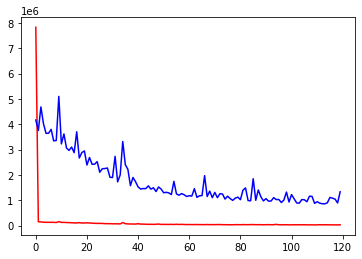

In [109]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

In [110]:
# demonstrate prediction
yhat = model.predict(X)
yhat_valid = model.predict(X_valid)

In [111]:
#def reverse(X,scale):
#    return X*scale[0]+scale[1]
#yhat = reverse(yhat,[scaler.data_range_[-1],scaler.data_min_[-1]])
#yhat_valid = reverse(yhat_valid,[scaler.data_range_[-1],scaler.data_min_[-1]])
#y = reverse(y,[scaler.data_range_[-1],scaler.data_min_[-1]])
#y_valid = reverse(y_valid,[scaler.data_range_[-1],scaler.data_min_[-1]])

In [112]:
form(yhat,y,mode=0)


Mean
[128.66754, '%3.9862818030118', '||||', 164.31143, '%1.0737506842575524']
[66.845184, '-%0.6679439559213355', '||||', 93.1933, '-%2.853275842770417']

Count
[531, 290]
[52, 624]
acc %0.7715430861723447

Max
[1607.124, '%27.60232808946914', '||||', 959.1826, '%5.4329425984991575']
[524.4238, '-%4.33348270618088', '||||', 1109.3203, '-%38.91332585458471']

Min
[0.11193848, '%0.10016216279395973', '||||', 5.0117188, '%0.10374566380375594']
[3.696289, '-%0.0008789751984927818', '||||', 0.12060547, '-%0.002277654578985988']

Means
1.8310344827586207 10.192307692307692 3.3771929824561404

Maxs
32 87 27
0 ---money was 100  and rate is 0.02187011657771687
money become  98.25738911108752
1 ---money was 98.25738911108752  and rate is 0.0027829172638389466
money become  98.03951037851219
2 ---money was 98.03951037851219  and rate is 0.013435133479108519
money become  96.9899862084889
3 +++money was 96.9899862084889  and rate is -0.018639390509063047
money become  98.43046852168493
4 ---mone

156 +++money was 1129.1704916045594  and rate is 0.02270646770003082
money become  1149.6000239263715
157 +++money was 1149.6000239263715  and rate is 0.002320226301965267
money become  1151.7253542330955
158 +++money was 1151.7253542330955  and rate is 0.012470143260655542
money become  1163.1691393879428
159 +++money was 1163.1691393879428  and rate is -0.005790282407547309
money become  1168.5356493828074
160 +++money was 1168.5356493828074  and rate is -0.031126857562535415
money become  1197.5175304581858
161 +++money was 1197.5175304581858  and rate is 0.0035408453349994318
money become  1200.896141229272
162 ---money was 1200.896141229272  and rate is 0.0017095623350220635
money become  1199.260305402013
163 +++money was 1199.260305402013  and rate is 0.004539345111492565
money become  1203.5979701853048
164 +++money was 1203.5979701853048  and rate is 0.014759438544636128
money become  1217.752668227149
165 +++money was 1217.752668227149  and rate is 0.02074371669389241
money b

money become  118385.92705233897
339 +++money was 118385.92705233897  and rate is 0.03771665463905105
money become  121943.73556454532
340 ---money was 121943.73556454532  and rate is -0.0014537344229567095
money become  121802.4837958814
341 ---money was 121802.4837958814  and rate is 0.013172992287057372
money become  120524.01566238602
342 +++money was 120524.01566238602  and rate is 0.12886502555969703
money become  132899.37969235014
343 +++money was 132899.37969235014  and rate is 0.037720237038235016
money become  136893.73498820048
344 +++money was 136893.73498820048  and rate is 0.03355348599263075
money become  140553.64616526276
345 +++money was 140553.64616526276  and rate is -0.01923834604023089
money become  142708.2090479947
346 ---money was 142708.2090479947  and rate is 0.009501540668760633
money become  141627.7897994928
347 +++money was 141627.7897994928  and rate is -0.025025730203349306
money become  144451.919000606
348 +++money was 144451.919000606  and rate is -

527 +++money was 51635655.243789114  and rate is 0.044985850874990074
money become  53486521.1566555
528 +++money was 53486521.1566555  and rate is -0.034685165219962344
money become  54964735.61110843
529 +++money was 54964735.61110843  and rate is -0.019974405019893893
money become  55839532.68258366
530 +++money was 55839532.68258366  and rate is 0.0364532935435371
money become  57461446.87194951
531 ---money was 57461446.87194951  and rate is 0.014426715699482173
money become  56800915.641652144
532 +++money was 56800915.641652144  and rate is 0.07271731217240207
money become  60092026.26143993
533 ---money was 60092026.26143993  and rate is 0.00650156438345495
money become  59780722.73427166
534 +++money was 59780722.73427166  and rate is -0.011498583559499398
money become  60328437.98312355
535 ---money was 60328437.98312355  and rate is 0.017096820532125134
money become  59506598.95970581
536 +++money was 59506598.95970581  and rate is 0.07883416301518587
money become  63244509.

717 +++money was 650239553.5273744  and rate is -0.0016163698243542024
money become  651077012.3134156
718 +++money was 651077012.3134156  and rate is -2.277654578985988e-05
money become  651088828.2880094
719 ---money was 651088828.2880094  and rate is 0.003926307104340054
money become  649051908.9333731
720 +++money was 649051908.9333731  and rate is -0.003387237409206323
money become  650803668.0812372
721 ---money was 650803668.0812372  and rate is 0.003383447575195042
money become  649049146.2793758
722 ---money was 649049146.2793758  and rate is 0.004928729220778916
money become  646500193.0449623
723 +++money was 646500193.0449623  and rate is -0.003900837969179727
money become  648509636.9890513
724 +++money was 648509636.9890513  and rate is -0.020090822634156402
money become  658891217.5689833
725 ---money was 658891217.5689833  and rate is 0.0034533480928020666
money become  657078194.2036732
726 ---money was 657078194.2036732  and rate is 0.006042259390548255
money become  

923 +++money was 14786823382.313772  and rate is -0.03906077280661924
money become  15247042910.052565
924 +++money was 15247042910.052565  and rate is -0.06271217004518814
money become  16008923267.709246
925 +++money was 16008923267.709246  and rate is -0.012243875114381297
money become  16165105037.450624
926 +++money was 16165105037.450624  and rate is 0.12835086315813915
money become  17818309808.538925
927 +++money was 17818309808.538925  and rate is -0.02425855988362302
money become  18162723848.037586
928 +++money was 18162723848.037586  and rate is -0.00517546842457306
money become  18237623529.1293
929 +++money was 18237623529.1293  and rate is -0.037238555463079415
money become  18778764476.55572
930 +++money was 18778764476.55572  and rate is 0.03236553729222491
money become  19263047406.76372
931 +++money was 19263047406.76372  and rate is 0.0160040687261076
money become  19508690595.590782
932 ---money was 19508690595.590782  and rate is 0.009413002732035158
money become 

1099 +++money was 386135321261.9017  and rate is -0.046577947883995496
money become  400466080707.04333
1100 ---money was 400466080707.04333  and rate is 0.0054960976132527595
money become  398712323372.8984
1101 +++money was 398712323372.8984  and rate is 0.02744423960809561
money become  407431193061.85596
1102 +++money was 407431193061.85596  and rate is -0.03394463109531376
money become  418451017973.0779
1103 ---money was 418451017973.0779  and rate is 0.010644266716018702
money become  414901987712.3392
1104 +++money was 414901987712.3392  and rate is -0.004116121437418574
money become  416262752366.88806
1105 +++money was 416262752366.88806  and rate is -0.013396395182244225
money become  420706044086.1153
1106 +++money was 420706044086.1153  and rate is -0.01870622828885482
money become  426976719294.0859
1107 ---money was 426976719294.0859  and rate is 0.002201695013866134
money become  426227669515.005
1108 ---money was 426227669515.005  and rate is 0.004300637151081865
money

1320 +++money was 18088069014399.715  and rate is 0.01128280783844593
money become  18250683310424.184
1321 +++money was 18250683310424.184  and rate is -0.006387550908739659
money become  18343571998495.832
1322 +++money was 18343571998495.832  and rate is -0.007291557114391556
money become  18450146550573.71
1323 +++money was 18450146550573.71  and rate is -0.007225163947668589
money become  18556364240455.04
1324 ---money was 18556364240455.04  and rate is 0.006853755306890585
money become  18455026595038.996
1325 +++money was 18455026595038.996  and rate is -0.006054926920859405
money become  18544064084643.84
1326 +++money was 18544064084643.84  and rate is 0.04413411158770475
money become  19196185756985.293
1327 +++money was 19196185756985.293  and rate is -0.005863568801599772
money become  19285872095617.867
1328 +++money was 19285872095617.867  and rate is -0.03373564755091807
money become  19804287214173.812
1329 +++money was 19804287214173.812  and rate is -0.00389547639470

money become  38948005035738.29
1446 +++money was 38948005035738.29  and rate is 0.01488542041640395
money become  39409955755434.16
1447 +++money was 39409955755434.16  and rate is 0.07520417882730213
money become  41771506304847.68
1448 ---money was 41771506304847.68  and rate is 0.014388652880378272
money become  41292601055493.33
1449 +++money was 41292601055493.33  and rate is -0.0022535837338807374
money become  41366748342478.94
1450 +++money was 41366748342478.94  and rate is 0.015223855961843835
money become  41868542240640.73
1451 +++money was 41868542240640.73  and rate is -0.005322339764046835
money become  42046100042881.62
1452 ---money was 42046100042881.62  and rate is 0.0032404308984577135
money become  41937538049432.305
1453 +++money was 41937538049432.305  and rate is 0.04515459617382245
money become  43446416373244.98
1454 +++money was 43446416373244.98  and rate is -0.02574143809783902
money become  44337536169000.375
1455 ---money was 44337536169000.375  and rate

85518315895432.36

In [123]:
1.57489491e+18

1.57489491e+18

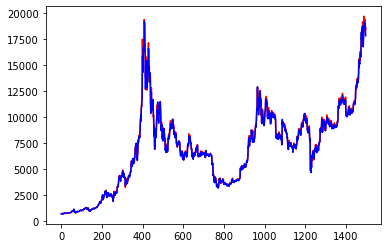

In [113]:
fig, ax = plt.subplots()
ax.plot(y,color="r")
ax.plot(yhat,color="b")

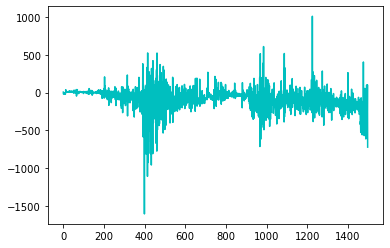

In [114]:
y=y.reshape((y.shape[0],1))
dif_y=yhat-y
fig, ax = plt.subplots()#figsize=(120, 60)
ax.plot(dif_y,color='c')

In [62]:
#X_valid, y_valid = split_sequences(dataset.values[1500:,:], n_steps)

In [115]:
form(yhat_valid,y_valid,mode=0)


Mean
[1075.7843, '%4.671419798774715', '||||', 1274.6584, '%1.502295825552182']
[696.2644, '-%0.5296074435751377', '||||', 647.7941, '-%3.0429197567550035']

Count
[121, 73]
[8, 166]
acc %0.779891304347826

Max
[3205.7773, '%19.610779364778928', '||||', 3812.0, '%6.060803939508275']
[1166.0586, '-%1.4536058527499285', '||||', 3382.5977, '-%14.3982777378171']

Min
[18.21875, '%0.2061725014385285', '||||', 214.3789, '%0.1466816755341549']
[93.66797, '-%0.003724462555054764', '||||', 8.480469, '-%0.005408885559465837']

Means
1.6575342465753424 20.625 3.54320987654321

Maxs
16 59 27
0 +++money was 100  and rate is 0.019502805081336172
money become  101.55398350888086
1 ---money was 101.55398350888086  and rate is 0.006563903722699438
money become  101.02284414237904
2 ---money was 101.02284414237904  and rate is 0.009606014096924298
money become  100.2496080163924
3 +++money was 100.2496080163924  and rate is 0.09990440810596946
money become  108.22986100897336
4 +++money was 108.2298610

money become  3016.459368863192
155 +++money was 3016.459368863192  and rate is -0.05929452283535808
money become  3158.9746335458103
156 ---money was 3158.9746335458103  and rate is -0.014536058527499285
money become  3122.3863423462367
157 +++money was 3122.3863423462367  and rate is -0.143982777378171
money become  3480.603604896801
158 +++money was 3480.603604896801  and rate is 0.10796312190922586
money become  3780.02258408713
159 +++money was 3780.02258408713  and rate is -0.08165092547945174
money become  4025.9488024508473
160 ---money was 4025.9488024508473  and rate is 0.005311028726205036
money become  4008.9116808339777
161 +++money was 4008.9116808339777  and rate is -0.07062489233855462
money become  4234.508832858185
162 +++money was 4234.508832858185  and rate is 0.11722531305270989
money become  4630.033678507818
163 +++money was 4630.033678507818  and rate is -0.011289190776797575
money become  4671.6818834403575
164 +++money was 4671.6818834403575  and rate is 0.025

money become  114045.467136668
345 ---money was 114045.467136668  and rate is 0.02372296195765511
money become  111889.72770209769
346 +++money was 111889.72770209769  and rate is -0.0059202922261059054
money become  112417.54386654205
347 +++money was 112417.54386654205  and rate is 0.03292991066720319
money become  115367.21752913711
348 +++money was 115367.21752913711  and rate is -0.08751289035613596
money become  123411.80487608637
349 ---money was 123411.80487608637  and rate is 0.0196225925051976
money become  121482.22654073859
350 +++money was 121482.22654073859  and rate is 0.04758854588325945
money become  126088.6568300886
351 +++money was 126088.6568300886  and rate is 0.009905199606017545
money become  127083.80689464927
352 +++money was 127083.80689464927  and rate is -0.013777798384400297
money become  128478.9519578807
353 +++money was 128478.9519578807  and rate is 0.005190415850687247
money become  129010.30535945427
354 +++money was 129010.30535945427  and rate is -

165689.0952712183

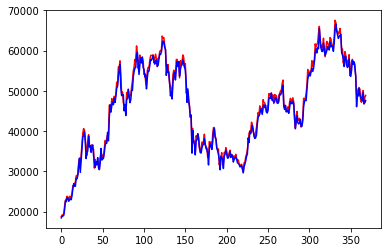

In [116]:
fig, ax = plt.subplots()
ax.plot(y_valid,color="r")
ax.plot(yhat_valid,color="b")

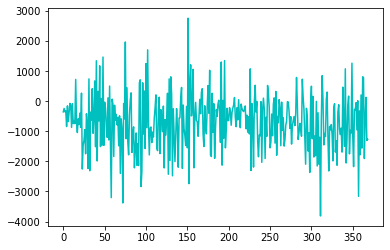

In [117]:
y_valid=y_valid.reshape((y_valid.shape[0],1))
dif_y_valid=yhat_valid-y_valid
fig, ax = plt.subplots()#figsize=(120, 60)
ax.plot(dif_y_valid,color='c')